## Loading up the packages

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO

## Defining the problem set-up variables

In [2]:
s = 2**4 * 2**5 * 2**5 # The total number of light samples
order = 2**4 # Order of the 2D fourier features
ind_r = 1.48899 # Refractive index of the acrilic glass
size = 2 * order + 1 # Usefull transformation
d = 2 * np.pi # Distance to the screen projection

In [3]:
# Random points for reproducible results 
tf.random.set_seed(12)

# Generation of uniformly distributed numbers from range (-π,π) type float64
x = tf.cast(tf.random.uniform((s,1), minval=-np.pi, maxval=np.pi), tf.float64)
y = tf.cast(tf.random.uniform((s,1), minval=-np.pi, maxval=np.pi), tf.float64)

2024-11-20 12:42:56.381688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading up image for optimization

In [73]:
url = 'https://github.com/szyczuk/Caustic-Design/blob/main/images/biblioteka_32.jpg?raw=true'

response = requests.get(url)
image_data = response.content  # Get raw image bytes

# Decode the image data into a TensorFlow tensor
target_photo1 = tf.image.decode_image(image_data, channels=3)  # Load as RGB
target_photo2 = tf.image.rgb_to_grayscale(target_photo1)      # Convert to grayscale
target_photo3 = tf.image.convert_image_dtype(target_photo2, tf.float64)  # Normalize pixel values
t_h,t_w=tf.squeeze(target_photo3).shape

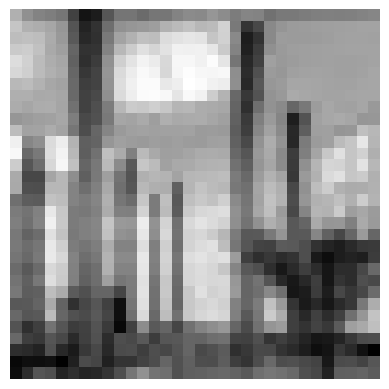

In [74]:
# Display the image using matplotlib
plt.imshow(target_photo3.numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

## Defining functions to generate Fourier Features

In [5]:
@tf.function
def fourier_features(tensor1, order):
    x = tensor1[:, 0]
    
    features = []
    features.append(tf.ones(shape=(s,), dtype=tf.float64))
    

    for i in range(1, order + 1):
        features.append(tf.math.sin(i * x))
        
    for j in range(1, order + 1):
        features.append(tf.math.cos(j * x))

    result = tf.stack(features, axis=-1)

    return result


@tf.function
def add_last_light(row):
    xo = tf.linspace(0, t_h-1, t_h)
    yo = tf.linspace(0, t_w-1, t_w)
    Xo, Yo = tf.meshgrid(xo, yo)
    shift = tf.constant(0.5, shape=(t_h, t_w, 2), dtype=tf.float64) #because I am looking at the distance to the middle of the square
    mesh = tf.stack((Yo, Xo), axis=-1) + shift
    adjusted = tf.reshape(row, (1, 1, 2))
    z = tf.norm(mesh - adjusted, axis=-1, keepdims=True)
    f_z = tf.exp(tf.constant([-10], dtype=tf.float64) * tf.square(z))
    z_sum = tf.reduce_sum(f_z)
    z_disp = tf.squeeze(f_z)
    z_fin = z_disp/z_sum
    
    return z_fin

## Performing one time calculations outside of iterative loops

In [6]:
%%time

tf.random.set_seed(1)

# fy = tf.random.normal((s, 2 * order + 1, 1))
# fx = tf.random.normal((s, 1, 2 * order + 1))


fx_t = fourier_features(x, order)
fx = tf.expand_dims(fx_t, axis=1)

fy_t = fourier_features(y, order)
fy = tf.expand_dims(fy_t, axis=-1)


# Outer produkt with shape (s, 2*order + 1, 2 * order + 1)
f = tf.matmul(fy, fx)


# creating sequence (0, -1, -2, -3, -4... -order, 1 ,2, 3 ,4 ... order)
first_row = tf.concat([tf.zeros(1, dtype=tf.float64), tf.range(-1, -order - 1, -1, dtype=tf.float64), tf.range(1, order + 1, dtype=tf.float64)], axis=0)


# making a matrix in order to differentiate with respect to x
ax = tf.tile(tf.expand_dims(first_row, axis=0), [size, 1])
ax = tf.expand_dims(ax, axis=0)
ax = tf.tile(ax, [s, 1, 1]) 

# making a matrix in order to differentiate with respect to y
ay = tf.tile(tf.expand_dims(first_row, axis=1), [1, size])
ay = tf.expand_dims(ay, axis=0)
ay = tf.tile(ay, [s, 1, 1]) 

CPU times: user 348 ms, sys: 245 ms, total: 593 ms
Wall time: 691 ms


## Initialize or load pre-trained weights

In [76]:
# If you are initializing new weights
w = tf.Variable(tf.zeros(shape=(size, size), dtype=tf.float64), trainable=True)

# If you want to use pre-trained weights

# weights_path = '' #your weights directory
# loaded_w = np.loadtxt(weights_path, delimiter=',', skiprows=0)
# w = tf.Variable(loaded_w, dtype=tf.float64, trainable=True)

## Defining the custom loss function

In [77]:
def compute_loss(target_photo, weights):
    
    # Reshape weights to match the shape of f
    w1 = tf.expand_dims(weights, axis=0)  # shape (1, size, size)  
    w1 = tf.tile(w1, [s, 1, 1]) # shape (s, size, size)
      
    # Weighted fourier basis functions for every point in the tensor 
    M = f * w1

    z_xy = tf.reduce_sum(M, axis=(1, 2)) # the value of the f(x,y)
    z_xy = tf.expand_dims(z_xy, axis=-1)
    full_dx = M * ax
    full_dy = M * ay


    df_dx = tf.reduce_sum(full_dx, axis=(1, 2))
    df_dx = tf.expand_dims(df_dx, axis=-1)

    df_dy = tf.reduce_sum(full_dy, axis=(1, 2))
    df_dy = tf.expand_dims(df_dy, axis=-1)

    normals = tf.concat([-df_dx, -df_dy, tf.ones(shape=(s,1), dtype=tf.float64)], axis=1)

    # Normalized vector so that ||n|| = 1
    n, _ = tf.linalg.normalize(normals, axis=1)

    n_3 = n[:,2][:, tf.newaxis]

    p_all = tf.concat([x,y,z_xy], axis=-1)
 

    # vector of [0,0,1]
    vec_one = tf.constant([0, 0, 1], dtype=tf.float64)

    # incident ray with matching dimentions basically (s, 3) [0,0,1]
    inc = tf.tile(tf.expand_dims(vec_one, axis=0), [s, 1])

    sqrt_term = tf.sqrt(1 - (ind_r ** 2) * (1 - n_3 ** 2))
    
    # calculating the transmitted rays
    t_i = sqrt_term * n + ind_r * (inc - n_3 * n)

    check_all = tf.math.logical_not(tf.math.is_nan(t_i))
    check = check_all[:,0]
    p = p_all[check]
    t = t_i[check]
    t_3 = t[:,2][:, tf.newaxis]

    proj = p + ((d - z_xy[check]) / t_3) * t

    conv = (t_h/(2*np.pi)) * (proj[:,:2]+np.pi)
    
    # estimating the light density from light samples
    result_tensor = tf.vectorized_map(add_last_light, conv)
    final_created = tf.reduce_sum(result_tensor, axis=0)

    per_fin = final_created / tf.reduce_mean(final_created)
    
    per_targ = tf.squeeze(target_photo) / tf.reduce_mean(target_photo)
    
    # calculating the MSE metric between the target photo distribution and the caustic projection light distribution
    loss = tf.reduce_mean(tf.square(per_fin - per_targ))
    
    return loss

In [78]:
vec_one = tf.constant([0, 0, 1], dtype=tf.float64)

# incident ray with matching dimentions basically (s, 3) [0,0,1]
inc = tf.tile(tf.expand_dims(vec_one, axis=0), [s, 1])

In [79]:
compute_loss(target_photo3, np.zeros(shape=(size,size)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.1583364769054869>

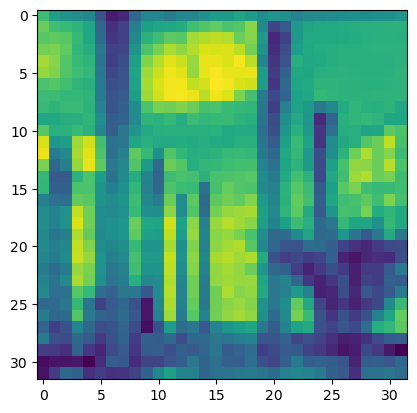

In [80]:
plt.imshow(target_photo3)

## Creating a function for computing gradients using Automatic Differentiation

In [35]:
@tf.function
def compute_loss_and_grads(w, target_photo):
    with tf.GradientTape() as tape:
        loss = compute_loss(target_photo, w)
    grads = tape.gradient(loss, w)
    return loss, grads

## Setting up the optimizer for Gradient Descent algorithm and learning rate parameter

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=3e-5)

# optimizer = keras.optimizers.SGD(
#     keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=1e-8, decay_steps=100, decay_rate=0.95
#     ), clipnorm=1, momentum=0,
#   nesterov=False)

In [18]:
def run_gradient_descent(w, target_photo3, iterations):

    for i in range(1, iterations + 1):

        loss, grads = compute_loss_and_grads(
            w, target_photo3
        )

        optimizer.apply_gradients([(grads, w)])
        
        
        if i % 10 == 0:
            print("Iteration %d: loss=%.8f" % (i, loss))

## Running the gradient descent algorithm to find the weigths of the model

In [19]:
%%time
run_gradient_descent(w, target_photo3, 1000)
#np.savetxt('/Users/mlot/Documents/Coding/Projekty/wagi_32_16spp1', w.numpy(), delimiter=',', comments='')

Iteration 10: loss=0.02541266
Iteration 20: loss=0.02441998
Iteration 30: loss=0.02397418
Iteration 40: loss=0.02374351
Iteration 50: loss=0.02360529
Iteration 60: loss=0.02350805
Iteration 70: loss=0.02343742
Iteration 80: loss=0.02337621
Iteration 90: loss=0.02331486
Iteration 100: loss=0.02324507
Iteration 110: loss=0.02317392
Iteration 120: loss=0.02309598
Iteration 130: loss=0.02300368
Iteration 140: loss=0.02303403
Iteration 150: loss=0.02281545


KeyboardInterrupt: 

In [105]:
compute_loss(target_photo3, np.zeros(shape=(size,size)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.1583364769054869>

## Visualization of the weights

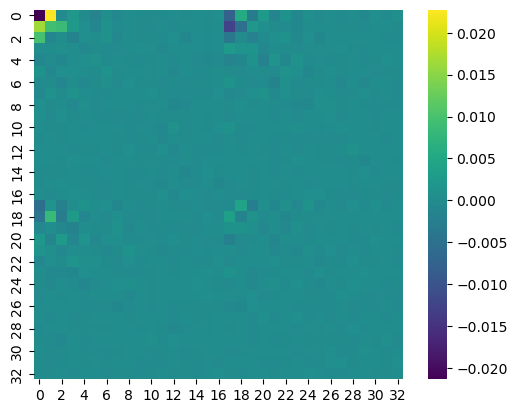

In [106]:
heatmap = sns.heatmap(w,cmap ='viridis')
heatmap.set_aspect('equal')

## Speed tests

In [24]:
%%time

w_test =  tf.Variable(tf.random.uniform(shape=(size, size), minval=-0.00001, maxval=0.00001, dtype=tf.float64), trainable=True)
w1 = tf.expand_dims(w, axis=0)  # shape (1, size, size)  
w1 = tf.tile(w1, [s, 1, 1]) # shape (s, size, size)

 
M = f * w1 # 8 s

z_xy = tf.reduce_sum(M, axis=(1, 2)) 
z_xy = tf.expand_dims(z_xy, axis=-1) 
full_dx = M * ax
full_dy = M * ay # 12 s


df_dx = tf.reduce_sum(full_dx, axis=(1, 2))
df_dx = tf.expand_dims(df_dx, axis=-1) 

df_dy = tf.reduce_sum(full_dy, axis=(1, 2))
df_dy = tf.expand_dims(df_dy, axis=-1) #  4 s

normals = tf.concat([-df_dx, -df_dy, tf.ones(shape=(s,1), dtype=tf.float64)], axis=1) # microseconds

n, _ = tf.linalg.normalize(normals, axis=1) # miliseconds

n_3 = n[:,2][:, tf.newaxis]

p_all = tf.concat([x,y,z_xy], axis=-1)



vec_one = tf.constant([0, 0, 1], dtype=tf.float64)


inc = tf.tile(tf.expand_dims(vec_one, axis=0), [s, 1])

sqrt_term = tf.sqrt(1 - (ind_r ** 2) * (1 - n_3 ** 2))

t_i = sqrt_term * n + ind_r * (inc - n_3 * n)

check_all = tf.math.logical_not(tf.math.is_nan(t_i))
check = check_all[:,0]
p = p_all[check]
t = t_i[check]
t_3 = t[:,2][:, tf.newaxis]
proj = p + ((d - z_xy[check]) / t_3) * t
conv = (t_h/(2*np.pi)) * (proj[:,:2]+np.pi) # miliseconds

result_tensor = tf.vectorized_map(add_last_light, conv) # 2.85 s
final_created = tf.reduce_sum(result_tensor, axis=0)

per_fin = final_created / tf.reduce_mean(final_created)

per_targ = tf.squeeze(target_photo3 / tf.reduce_mean(target_photo3))

loss = tf.reduce_mean(tf.square(per_fin - per_targ)) # miliseconds

CPU times: user 1.58 s, sys: 1.61 s, total: 3.19 s
Wall time: 2.9 s


In [25]:
%time result_tensor = tf.vectorized_map(add_last_light, conv)

CPU times: user 1.16 s, sys: 314 ms, total: 1.47 s
Wall time: 720 ms


In [26]:
np.std(per_fin)

0.27969676208590843

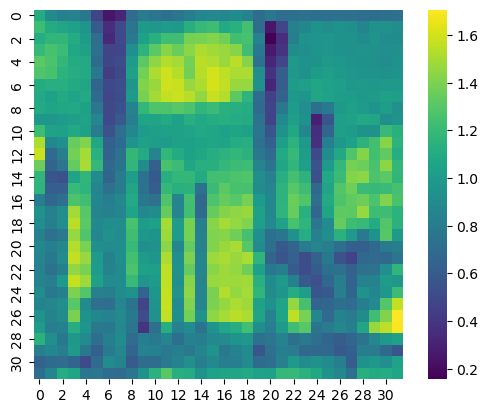

In [33]:
heatmap = sns.heatmap(per_fin,cmap ='viridis')
heatmap.set_aspect('equal')

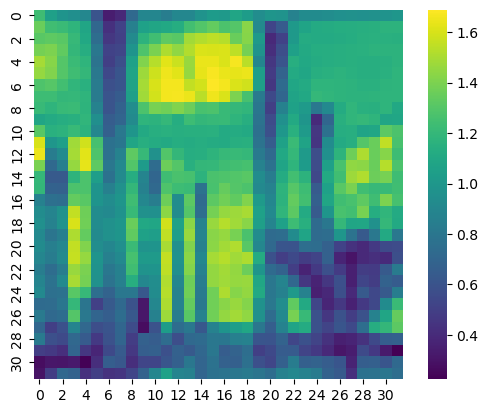

In [32]:
heatmap = sns.heatmap(per_targ,cmap ='viridis')
heatmap.set_aspect('equal')